# Hometask 20
## ML Pro 2022-05 Vladimir Vasilev

Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов

Цель:
В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.


Описание/Пошаговая инструкция выполнения домашнего задания:
Подготовка:

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха).
3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html).
4. Моделирование:
Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).
5. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.
6. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.
7. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.
8. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.
9. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.
Несколько советов:
для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.
Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза.
Теперь вы круто разбираетесь в прогнозировании и временных рядах :)

Критерии оценки:
Базовый EDA - 2 балла.
Генерация дополнительных признаков - 2 балла.
Baseline прогноз и проверка качества - 1 балл.
Построение различных моделей - 5 баллов.


Рекомендуем сдать до: 01.09.2022

In [2]:
# Импорт библиотек:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
d0 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', usecols=['date_time', 'holiday', 'temp', 'traffic_volume'])

# 1. EDA

Типы данных

In [4]:
d0.dtypes

holiday            object
temp              float64
date_time          object
traffic_volume      int64
dtype: object

In [5]:
d0.holiday.value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

Преобразуем holiday feature в число и растянем на весь день

In [6]:
d0.date_time = pd.to_datetime(d0.date_time)
d0['date'] = d0.date_time.dt.strftime('%Y-%m-%d')

In [7]:
d0.holiday = np.where(d0.holiday == 'None', 0, 1)
d_holiday = d0.loc[d0.holiday == 1, ['date']]['date'].unique()
d0['holiday_day'] = np.where(d0.date.isin(d_holiday), 1, 0)

Нули в температуре заменим на np.nan

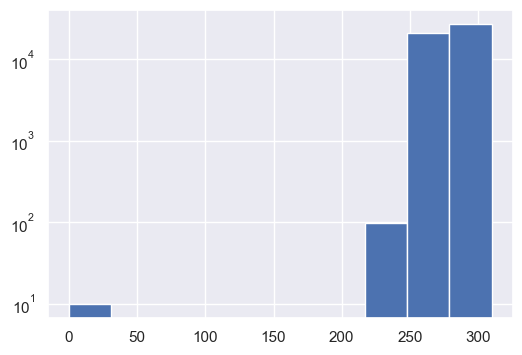

In [8]:
plt.figure(figsize=(6,4))
d0.temp.hist(log=True)
d0.temp = np.where(d0.temp == 0, np.nan, d0.temp)

<AxesSubplot:>

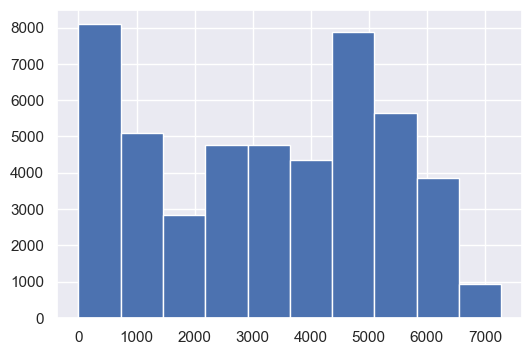

In [9]:
plt.figure(figsize=(6,4))
d0.traffic_volume.hist()

Имеют место дубликаты:

In [10]:
d0.value_counts()

holiday  temp     date_time            traffic_volume  date        holiday_day
0        274.790  2013-04-18 22:00:00  1532            2013-04-18  0              6
         287.150  2013-05-19 10:00:00  3591            2013-05-19  0              6
         271.090  2018-04-14 09:00:00  1755            2018-04-14  0              5
         272.800  2013-04-11 01:00:00  330             2013-04-11  0              5
         290.940  2015-07-06 13:00:00  4307            2015-07-06  0              5
                                                                                 ..
         275.950  2017-03-05 06:00:00  1011            2017-03-05  0              1
                  2017-04-28 09:00:00  5316            2017-04-28  0              1
                  2018-03-17 21:00:00  3351            2018-03-17  0              1
                  2018-04-13 07:00:00  6585            2018-04-13  0              1
1        299.487  2018-05-28 00:00:00  1088            2018-05-28  1             

Удаляем дубликаты

In [11]:
d1 = d0.drop_duplicates(subset=['date_time'])
print(d0.shape, d1.shape)

(48204, 6) (40575, 6)


Переиндексация равномерным рядом с шагом 1 час

In [12]:
start_date = d1.date_time.min()
end_date = d1.date_time.max()
old_date_time_index = pd.DatetimeIndex(d1['date_time'])
d1.set_index(old_date_time_index, inplace=True)
d1.rename_axis(None, inplace=True)
d1

,holiday,temp,date_time,traffic_volume,date,holiday_day
2012-10-02 09:00:00,0,288.28,2012-10-02 09:00:00,5545,2012-10-02,0
2012-10-02 10:00:00,0,289.36,2012-10-02 10:00:00,4516,2012-10-02,0
2012-10-02 11:00:00,0,289.58,2012-10-02 11:00:00,4767,2012-10-02,0
2012-10-02 12:00:00,0,290.13,2012-10-02 12:00:00,5026,2012-10-02,0
2012-10-02 13:00:00,0,291.14,2012-10-02 13:00:00,4918,2012-10-02,0
...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,2018-09-30 19:00:00,3543,2018-09-30,0
2018-09-30 20:00:00,0,282.76,2018-09-30 20:00:00,2781,2018-09-30,0
2018-09-30 21:00:00,0,282.73,2018-09-30 21:00:00,2159,2018-09-30,0
2018-09-30 22:00:00,0,282.09,2018-09-30 22:00:00,1450,2018-09-30,0


In [13]:
if 'date_time' in d1.columns:
    d2 = d1.copy()
    d2.drop('date_time', axis=1, inplace=True)
d2 = d2.asfreq('H')
d2

,holiday,temp,traffic_volume,date,holiday_day
2012-10-02 09:00:00,0.0,288.28,5545.0,2012-10-02,0.0
2012-10-02 10:00:00,0.0,289.36,4516.0,2012-10-02,0.0
2012-10-02 11:00:00,0.0,289.58,4767.0,2012-10-02,0.0
2012-10-02 12:00:00,0.0,290.13,5026.0,2012-10-02,0.0
2012-10-02 13:00:00,0.0,291.14,4918.0,2012-10-02,0.0
...,...,...,...,...,...
2018-09-30 19:00:00,0.0,283.45,3543.0,2018-09-30,0.0
2018-09-30 20:00:00,0.0,282.76,2781.0,2018-09-30,0.0
2018-09-30 21:00:00,0.0,282.73,2159.0,2018-09-30,0.0
2018-09-30 22:00:00,0.0,282.09,1450.0,2018-09-30,0.0


В 2015 г имеется существенный разрыв в данных, в 2016м - отсутствует много точек

<AxesSubplot:>

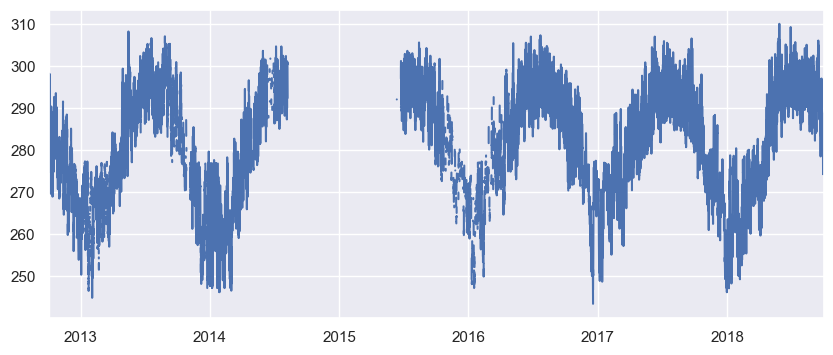

In [14]:
plt.figure(figsize=(10,4))
d2.temp.plot()

<AxesSubplot:>

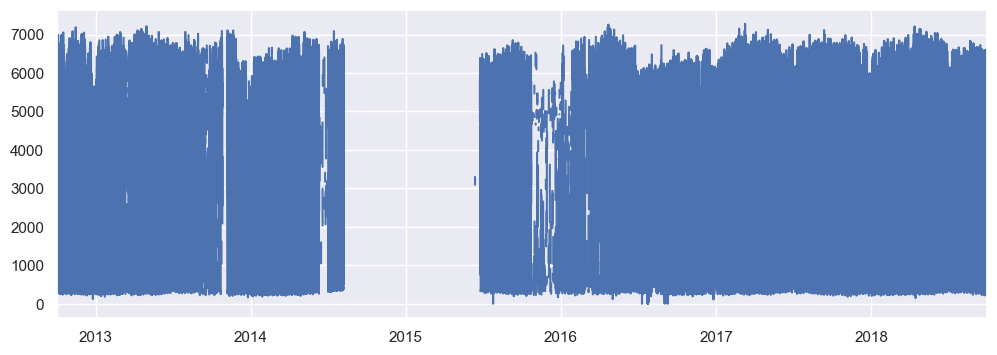

In [15]:
plt.figure(figsize=(12, 4))
d2.traffic_volume.plot()

Линейная интерполяция с параметрами по умолчанию, на графике ниже отображены только проинтерполированные данные. Видно, что в период 2014-2016 г данные "не очень". Для прогнозов лучше взять данные с минимумом интерполированных точек - 2017-2018 г

In [16]:
data = d2.copy()

<AxesSubplot:title={'center':'Точки, значения в которых были проинтерполированы'}>

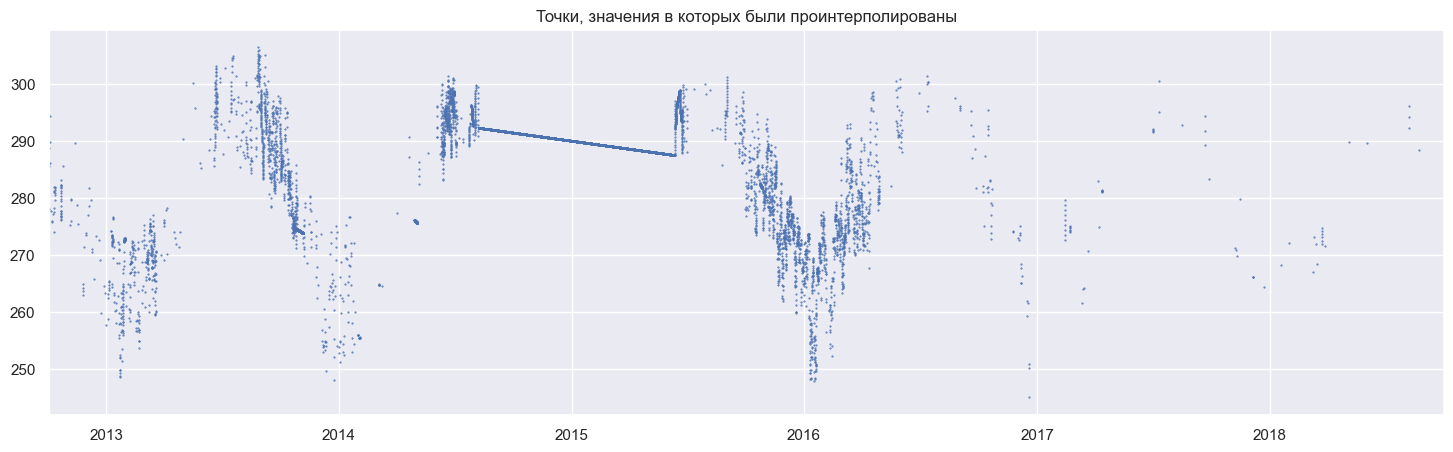

In [17]:
data['temp_interpolated'] = data.temp.interpolate()
data['temp_interpolated_only'] = np.where(data.temp.isna() == True, data.temp_interpolated, np.nan)
plt.figure(figsize=(18, 5))
data['temp_interpolated_only'].plot(marker='.', linestyle='none', ms=1, title='Точки, значения в которых были проинтерполированы')

<AxesSubplot:title={'center':'Точки, значения в которых были проинтерполированы'}>

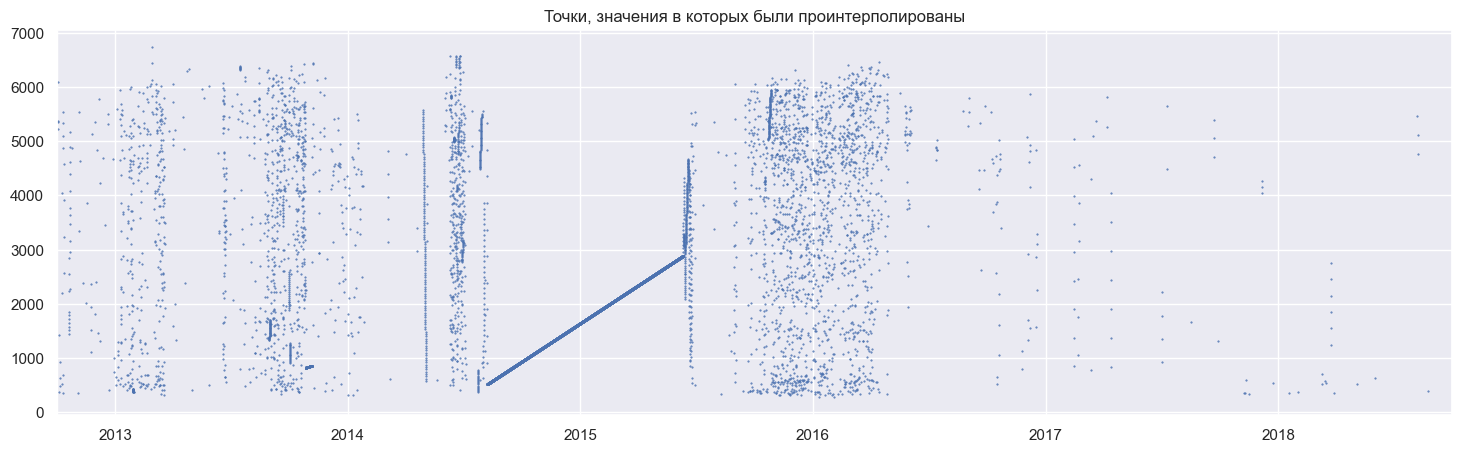

In [18]:
data['traffic_volume_interpolated'] = data.traffic_volume.interpolate()
data['traffic_volume_interpolated_only'] = np.where(data.traffic_volume.isna() == True, data.traffic_volume_interpolated, np.nan)
plt.figure(figsize=(18, 5))
data['traffic_volume_interpolated_only'].plot(marker='.', linestyle='none', ms=1, title='Точки, значения в которых были проинтерполированы')

### Наименьшее количество пропусков - с 05.2016 г, поэтому возьмем в работу только этот период

In [19]:
data = data['2016-04-30':'2018-09-30']
data.describe()

,holiday,temp,traffic_volume,holiday_day,temp_interpolated,temp_interpolated_only,traffic_volume_interpolated,traffic_volume_interpolated_only
count,21065.000000,21065.000000,21065.000000,21065.000000,21216.000000,151.000000,21216.000000,151.000000
mean,0.001234,283.332713,3300.796107,0.029290,283.324633,282.197394,3301.837222,3447.076159
std,0.035111,12.540981,1958.154964,0.168623,12.537017,11.957394,1956.938645,1779.056008
min,0.000000,243.390000,0.000000,0.000000,243.390000,245.065000,0.000000,336.000000
25%,0.000000,274.000000,1293.000000,0.000000,274.000000,273.643857,1296.000000,1769.342857
50%,0.000000,285.970000,3494.000000,0.000000,285.950000,281.671000,3497.500000,3997.200000
75%,0.000000,293.350000,4919.000000,0.000000,293.340000,292.246000,4921.000000,5027.500000
max,1.000000,310.070000,7280.000000,1.000000,310.070000,301.500000,7280.000000,5887.500000



### Дополнительные признаки - день недели и час

In [20]:
data['hour'] = data.index.to_series().dt.hour
data['day'] = data.index.to_series().dt.day
data['weekday'] = data.index.to_series().dt.weekday
data['day_of_year'] = data.index.to_series().dt.dayofyear
data['month'] = data.index.to_series().dt.month
data['year'] = data.index.to_series().dt.year

# Моделирование

### Определяем длину интервала исследования
### Делим на тренировочный и тестовый наборы - одна неделя на тест

In [21]:
n_data_points = 24 * 35 # число шагов

X_ = data[-n_data_points:]
X_.temp = X_.temp_interpolated
X_.traffic_volume = X_.traffic_volume_interpolated
X = X_.loc[:, ['holiday_day', 'temp', 'traffic_volume', 'traffic_volume_interpolated_only', 'weekday', 'hour']]
X.reset_index(drop=True, inplace=True)

In [22]:
n_test = 24*7 # число шагов в тестовой выборке
X_train = X[:-n_test]
X_test = X[-n_test:]

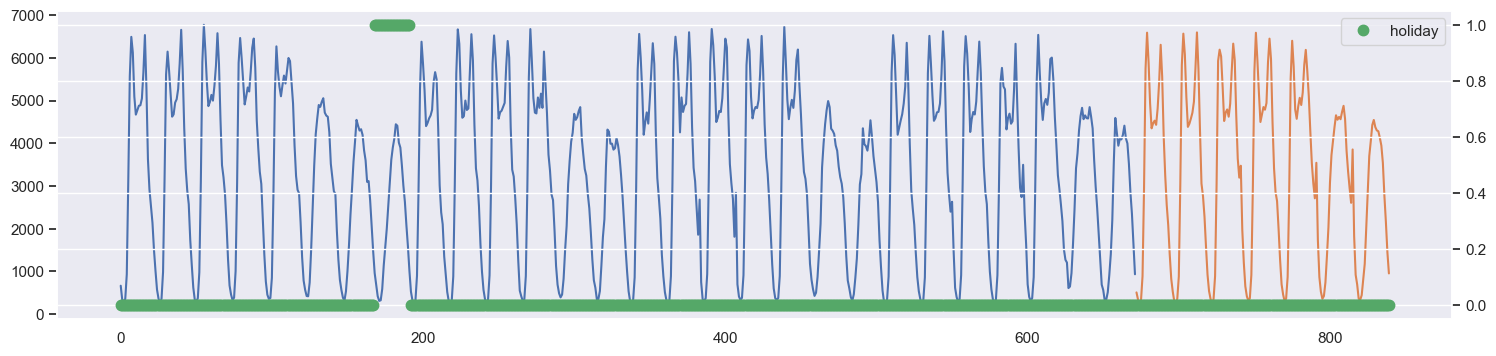

In [23]:
plt.figure(figsize=(18, 4))
X_train['traffic_volume'].plot()
X_test['traffic_volume'].plot()
X.holiday_day.plot(secondary_y=True, marker='.', linestyle='none', ms=15)
plt.legend(['holiday',])

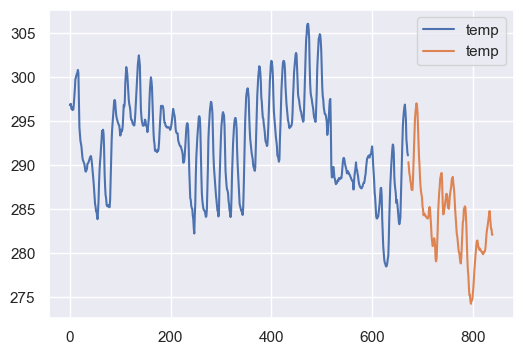

In [24]:
plt.figure(figsize=(6,4))
X_train['temp'].plot()
X_test['temp'].plot()
plt.legend()

# Прогноз трафика

## Baseline forecast
Среднее значение трафика за несколько недель сохраняет утренние пики и спад по выходным

<AxesSubplot:>

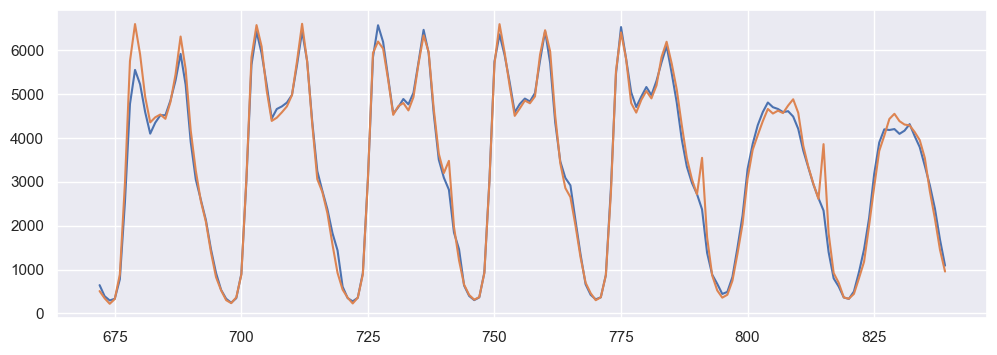

In [25]:
y_pred_baseline = X.groupby(['weekday', 'hour'])['traffic_volume'].mean()
y_pred_baseline.index = X_test.index
plt.figure(figsize=(12,4))
y_pred_baseline.plot()
X_test['traffic_volume'].plot()

## Выделение компонент - тренд, сезонность

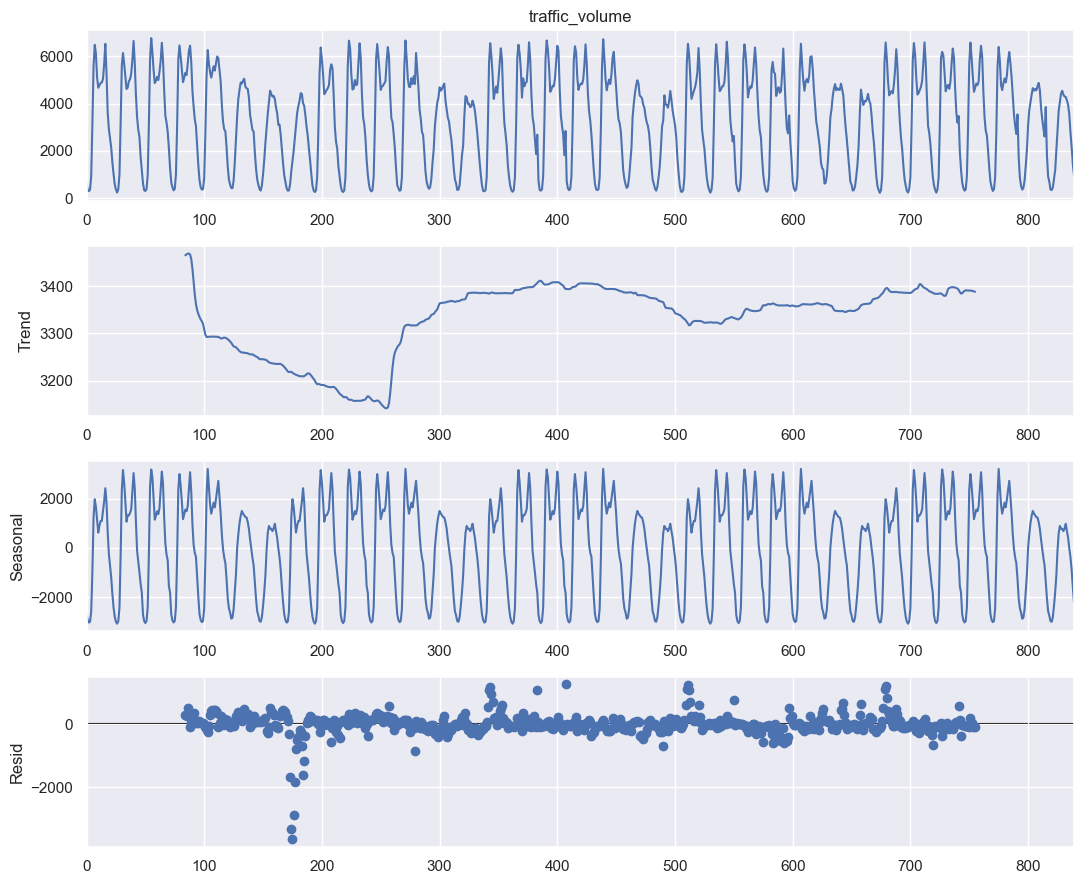

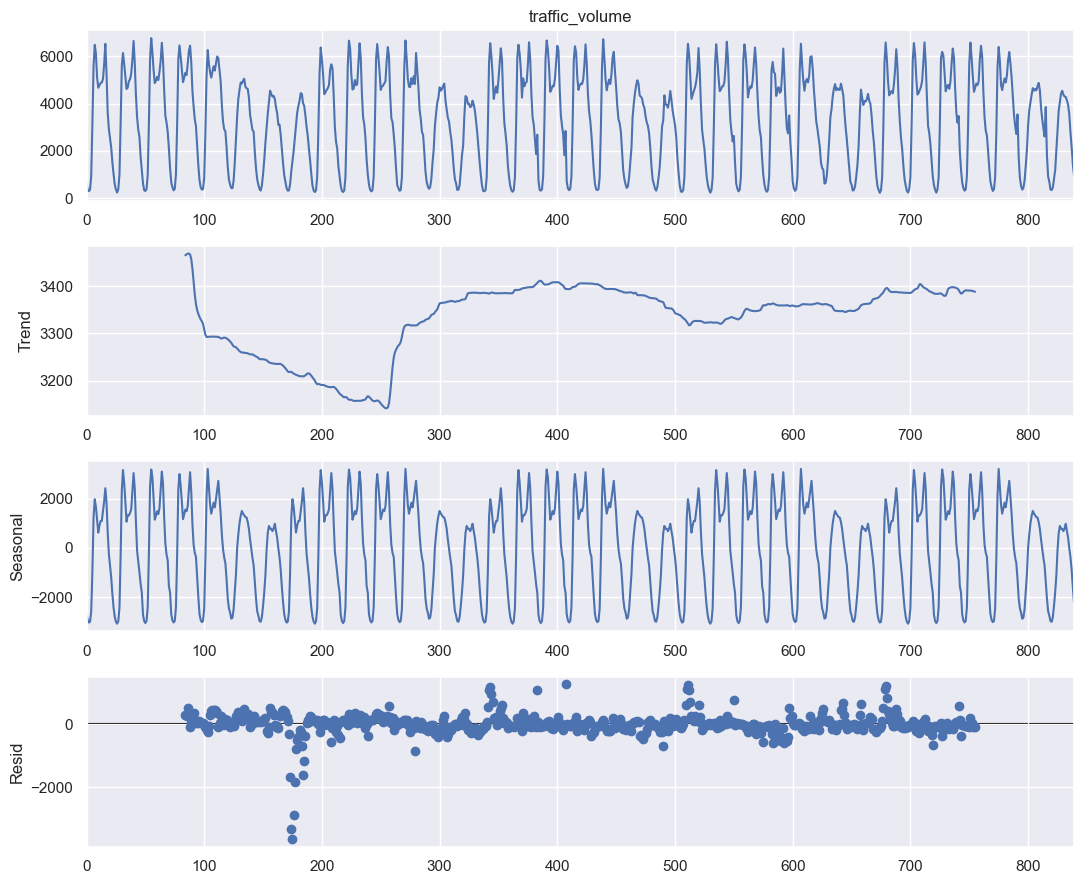

In [26]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(X.traffic_volume, period=24*7)
decompose.plot()

## Double Exponential Smooting
Метод хорошо апроксимирует ряд

In [27]:
def double_exponential_smoothing(series, alpha, beta):
    """
    :param series:  dataset with timeseries
    :param alpha:   float [0.0, 1.0], smoothing parameter for level
    :param beta:    float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        # forecasting
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level = level
        level = alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
    :param series:  dataset with timestamps
    :param alphas:  list of floats, smoothing parameters for level
    :param betas:   list of floats, smoothing parameters for trend
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        plt.plot(series.values, label = "Actual")
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

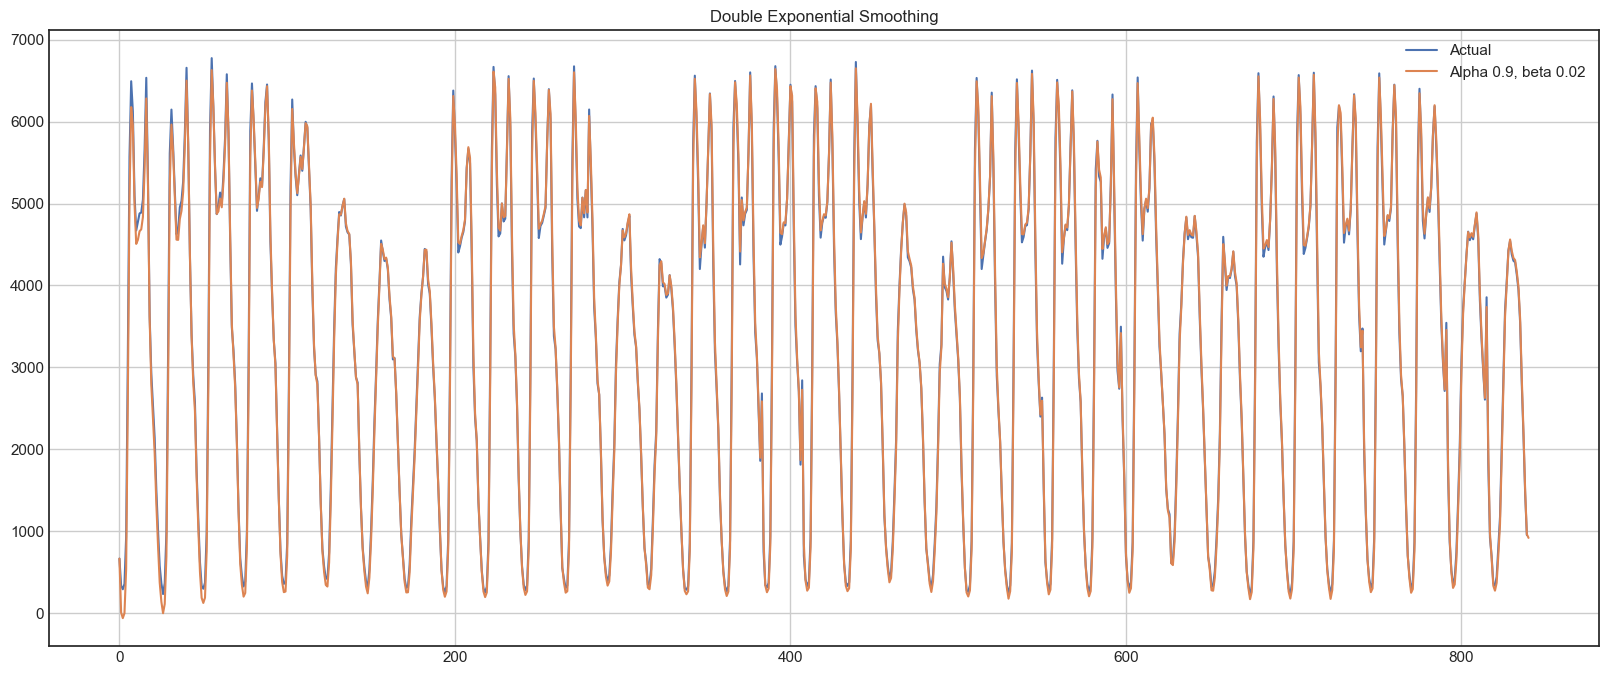

In [28]:
plotDoubleExponentialSmoothing(X.traffic_volume, alphas=[0.9,], betas=[0.02,])

## Модель Sarima
### Проверка критерия стационарности ряда, получение "хороших" графиков автокорреляций и частичной автокорреляции дифференцированием

adf:  -2.5071044689968254
Критерий Дики-Фуллера: p=0.1138
Critical values:  {'1%': -3.438369485934381, '5%': -2.865079774912655, '10%': -2.5686548826226527}
есть единичные корни, ряд не стационарен


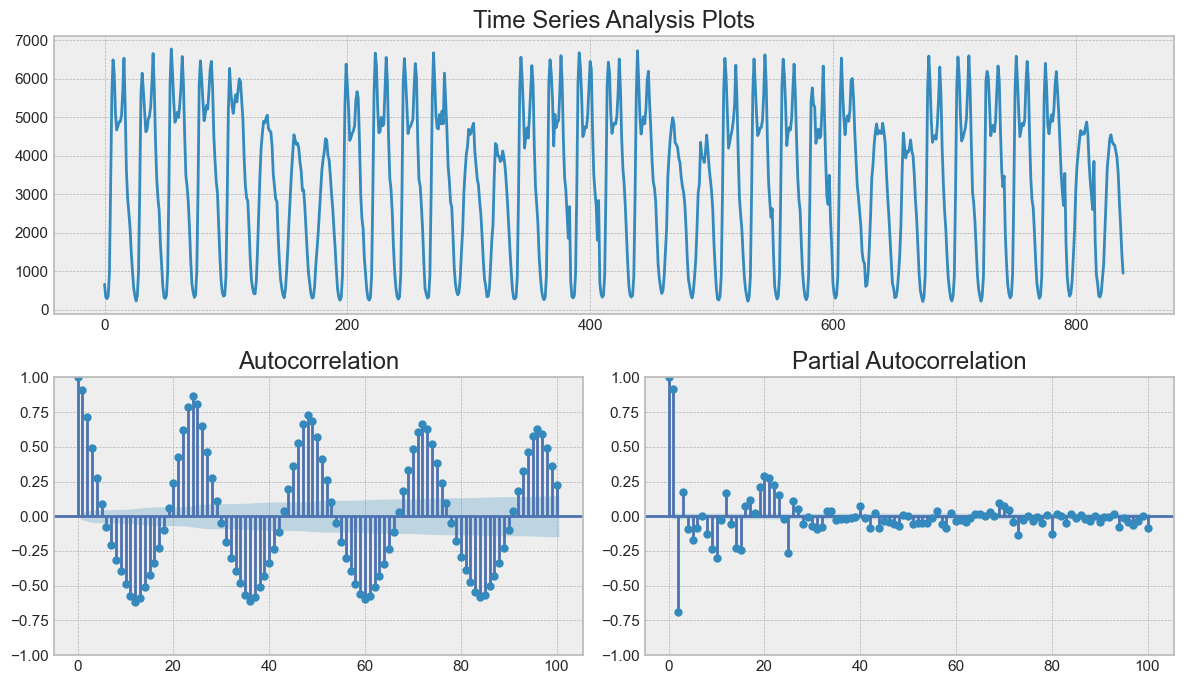

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        test = sm.tsa.stattools.adfuller(y)

        print ('adf: ', test[0])
        print ("Критерий Дики-Фуллера: p=%.4f" % test[1])
        print('Critical values: ', test[4])
        if test[0] > test[4]['5%']:
            print('есть единичные корни, ряд не стационарен')
        else:
            print ('единичных корней нет, ряд стационарен')

        plt.tight_layout()
    return

tsplot(X.traffic_volume, lags=100)

### Несмотря на то, что по критерию стационарности ряд прошел, ACF PACF имеют не очень хороший вид. Продифференцируем с шагом 1 неделя, 1 день, 1 час

adf:  -10.115788002931657
Критерий Дики-Фуллера: p=0.0000
Critical values:  {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
единичных корней нет, ряд стационарен
adf:  -4.757314057631352
Критерий Дики-Фуллера: p=0.0001
Critical values:  {'1%': -3.438272329479064, '5%': -2.8650369467745573, '10%': -2.568632068251301}
единичных корней нет, ряд стационарен
adf:  -20.80420730613206
Критерий Дики-Фуллера: p=0.0000
Critical values:  {'1%': -3.438369485934381, '5%': -2.865079774912655, '10%': -2.5686548826226527}
единичных корней нет, ряд стационарен


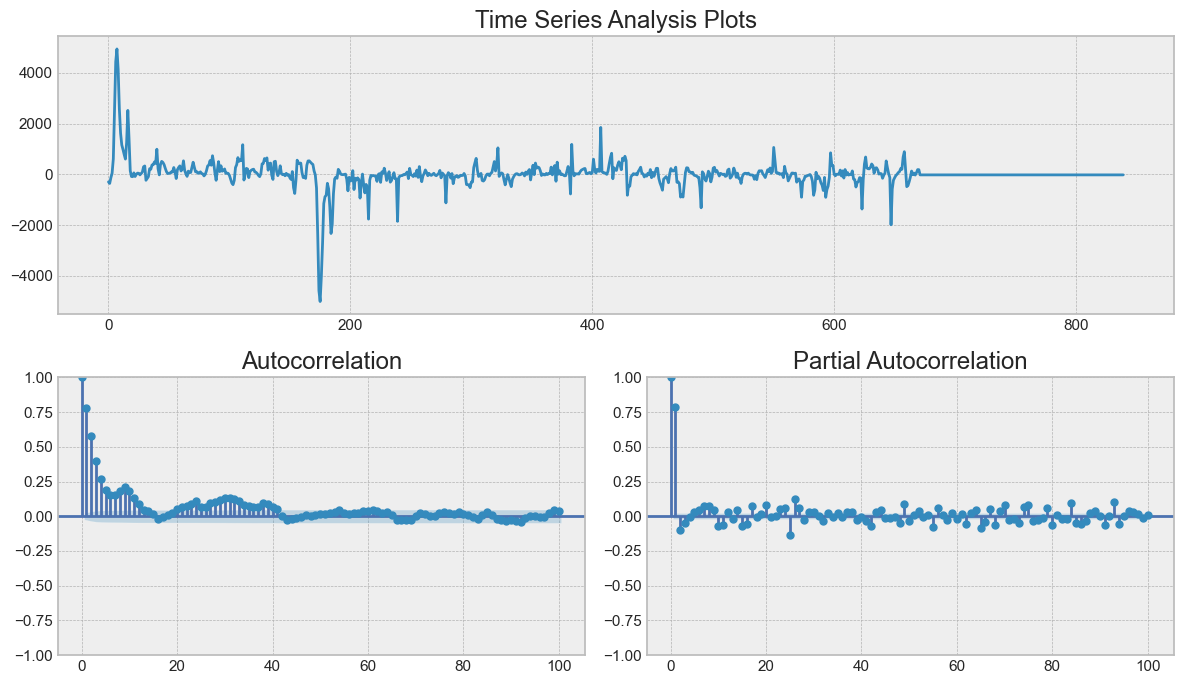

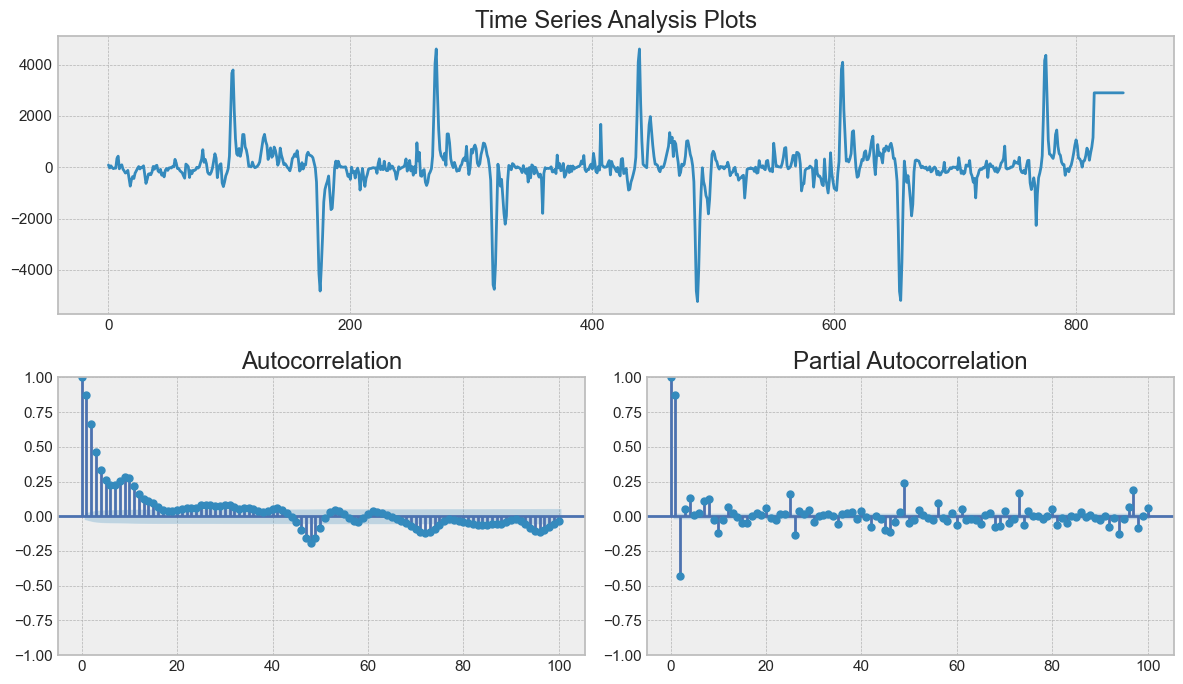

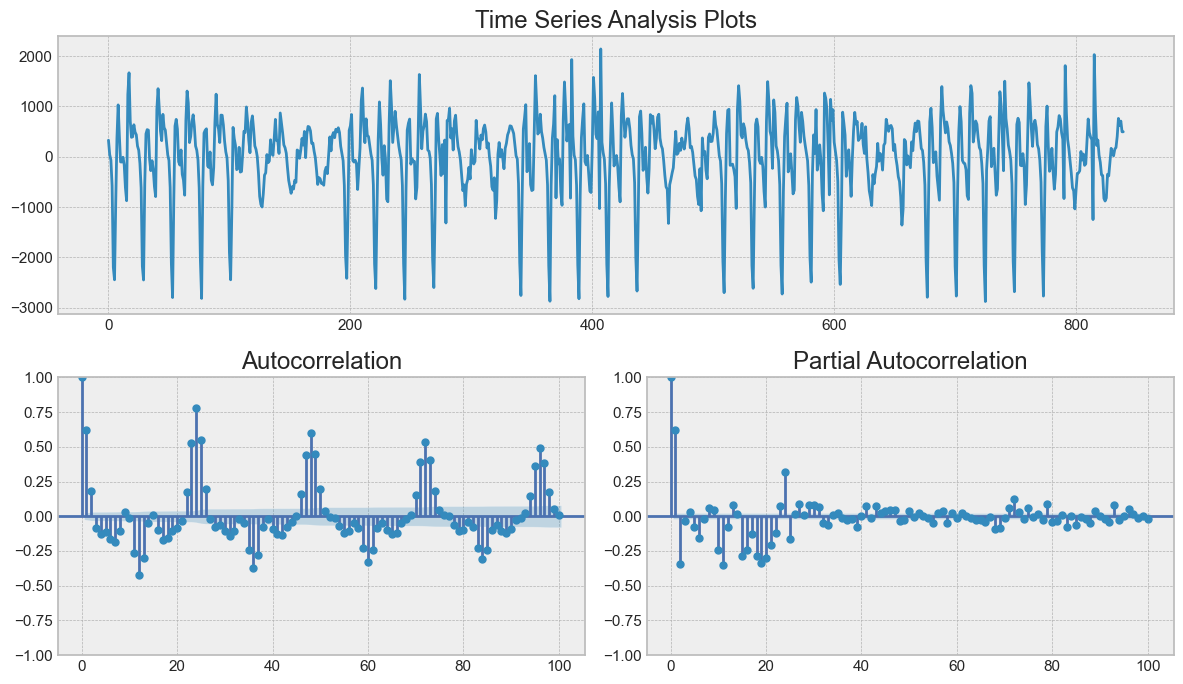

In [30]:
X['traffic_volume_diff_week'] = X['traffic_volume'].diff(periods=-24*7).fillna(method='ffill')
X['traffic_volume_diff_day'] = X['traffic_volume'].diff(periods=-24).fillna(method='ffill')
X['traffic_volume_diff_hour'] = X['traffic_volume'].diff(periods=-1).fillna(method='ffill')
tsplot(X.traffic_volume_diff_week, lags=100)
tsplot(X.traffic_volume_diff_day, lags=100)
tsplot(X.traffic_volume_diff_hour, lags=100)

### Видно, что первый график - трафик, продифференцированный с шагом 1 неделя, существенно более стационарен

### Применение преобразования Box-cox, а после - дифференцирование с шагом 1 неделя, не дает существенного изменения в графиках ACF PACF

Lambda_box-cox:  0.7638287613481912
nans  0
adf:  -10.08393783726366
Критерий Дики-Фуллера: p=0.0000
Critical values:  {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
единичных корней нет, ряд стационарен


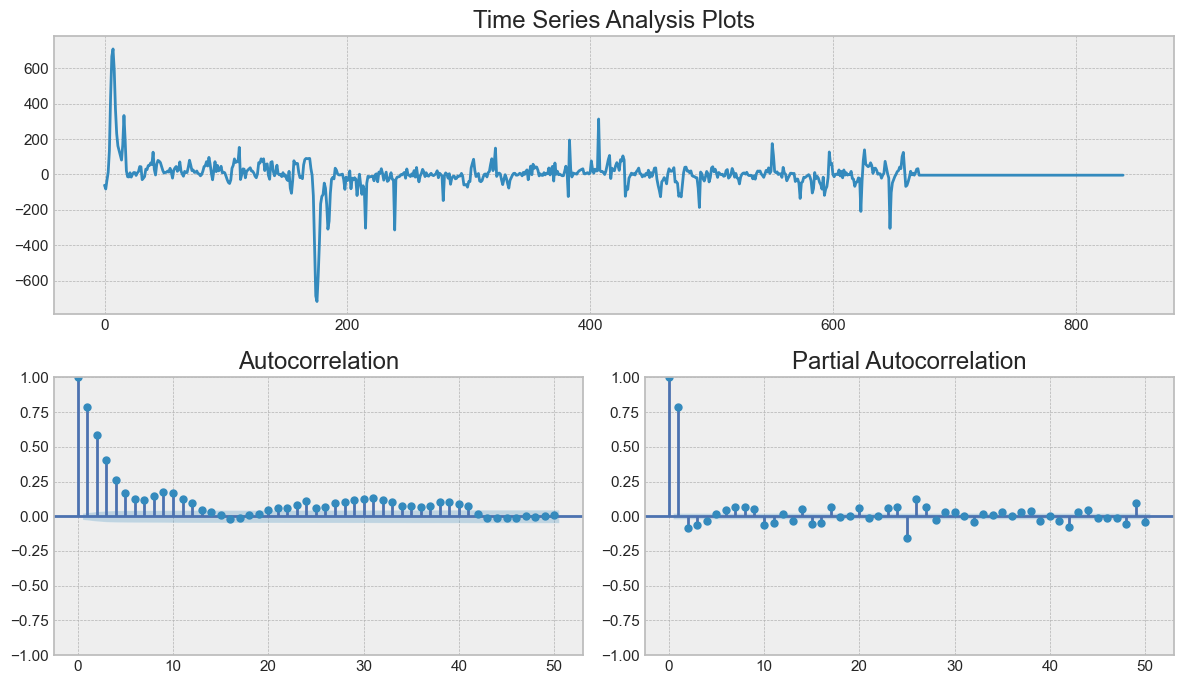

In [31]:
X['traffic_volume_bc'], lambda_bc = boxcox(X.traffic_volume)
X['traffic_volume_bc_diff_week'] = X['traffic_volume_bc'].diff(periods=-24*7).fillna(method='ffill')
print('Lambda_box-cox: ', lambda_bc)
print('nans ', X.traffic_volume_bc.isna().sum())
tsplot(X.traffic_volume_bc_diff_week, lags=50)

In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
def plotSARIMA(series, model, n_steps=24*7, s=24*7, d=1, plot_intervals=True, alpha=0.2, test=None):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    if test is not None:
        plt.plot(test, "r--", label="test",  color = "grey")

    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")

    plt.legend()
    plt.grid(True)

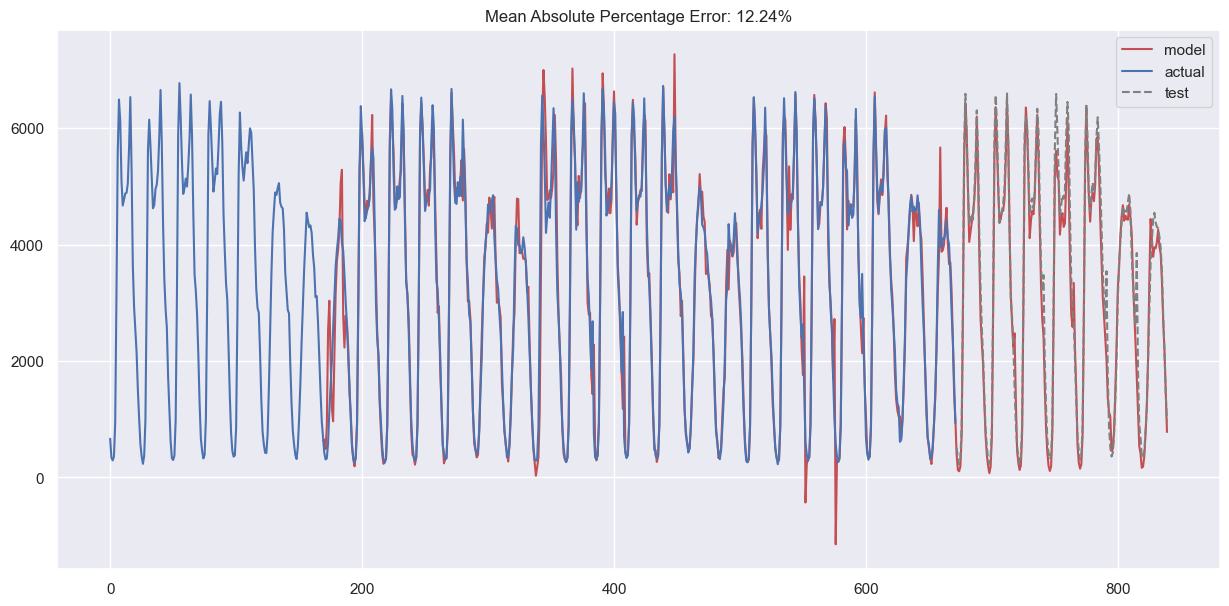

In [34]:
p, d, q = 0, 1, 0
P, D, Q = 0, 1, 0
s = 24*7

model = sm.tsa.statespace.SARIMAX(X_train.traffic_volume,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

plotSARIMA(pd.DataFrame(X_train.traffic_volume), model, n_steps=24*7, s=s, d=d, plot_intervals=False, alpha=0.5, test=X_test['traffic_volume'])

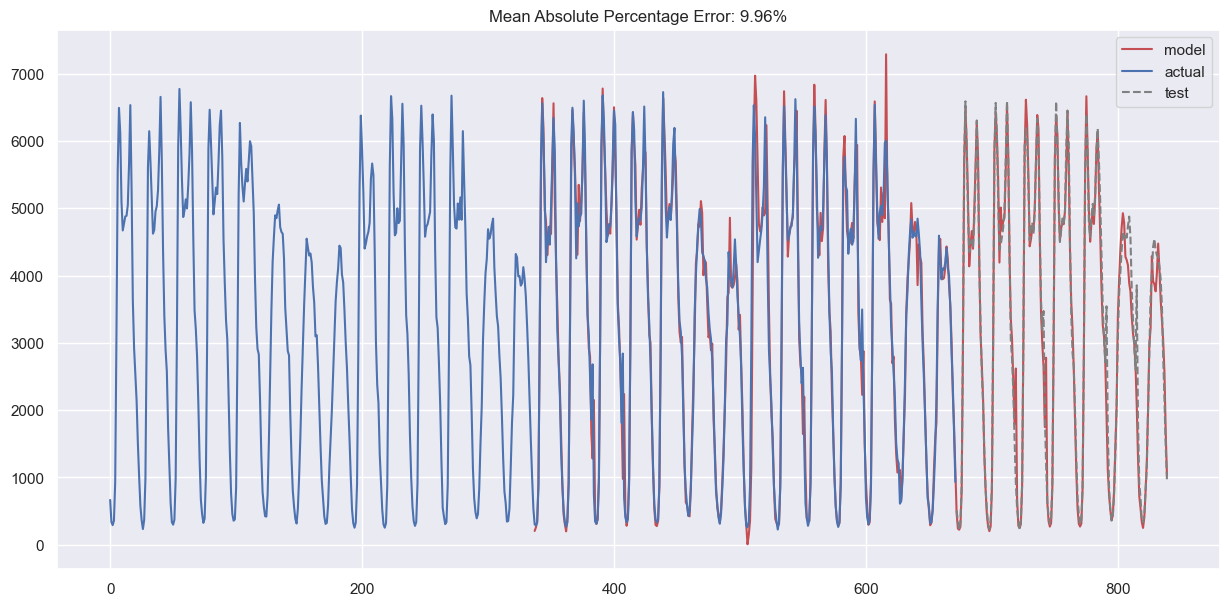

In [35]:
p, d, q = 0, 1, 0
P, D, Q = 0, 1, 0
s = 24*14

model = sm.tsa.statespace.SARIMAX(X_train.traffic_volume,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

plotSARIMA(pd.DataFrame(X_train.traffic_volume), model, n_steps=24*7, s=s, d=d, plot_intervals=False, alpha=0.5, test=X_test['traffic_volume'])

In [36]:
forecast = model.get_forecast(steps=24*7)
sarima_mape = mean_absolute_percentage_error(X_test.traffic_volume, forecast.predicted_mean)
baseline_mape = mean_absolute_percentage_error(X_test.traffic_volume, y_pred_baseline)
print(f'SARIMA MAPE: {sarima_mape:.1f}, baseline MAPE: {baseline_mape:.1f}')

SARIMA MAPE: 9.2, baseline MAPE: 6.4


## Linear regression

In [37]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature,
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [38]:
def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            data["lag_{}_{}".format(c, i)] = data[c].shift(i)
    return data


def timeseries_train_test_split(y, X=None, test_size=0.2):
    """
    Performs train-test split with respect to time series structure
    :param X:         x data
    :type X:           pd.DataFrame
    :param y:         y data
    :type y:           pd.Series
    :param test_size: percent of test data from the end of series (0-1)
    :type test_size:   float
    """
    test_index = int(len(y)*(1-test_size))

    if X is None:
        y_train = y.iloc[:test_index]
        y_test = y.iloc[test_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, X_test, y_train, y_test

In [39]:
n_data_points = 24 * 93 # число шагов

X_ = data[-n_data_points:]
X_.temp = X_.temp_interpolated
X_.traffic_volume = X_.traffic_volume_interpolated
X_lr = X_.loc[:, ['holiday_day', 'temp', 'traffic_volume',]]

In [40]:
def prepareData(data, lag_start=1, lag_end=24, test_steps=24*14):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = data.weekday.apply(code_mean(X, 'weekday', "traffic_volume").get)
    data["hour_average"] = data.hour.apply(code_mean(X, 'hour', "traffic_volume").get)

    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    test_index = data.shape[0] - test_steps
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

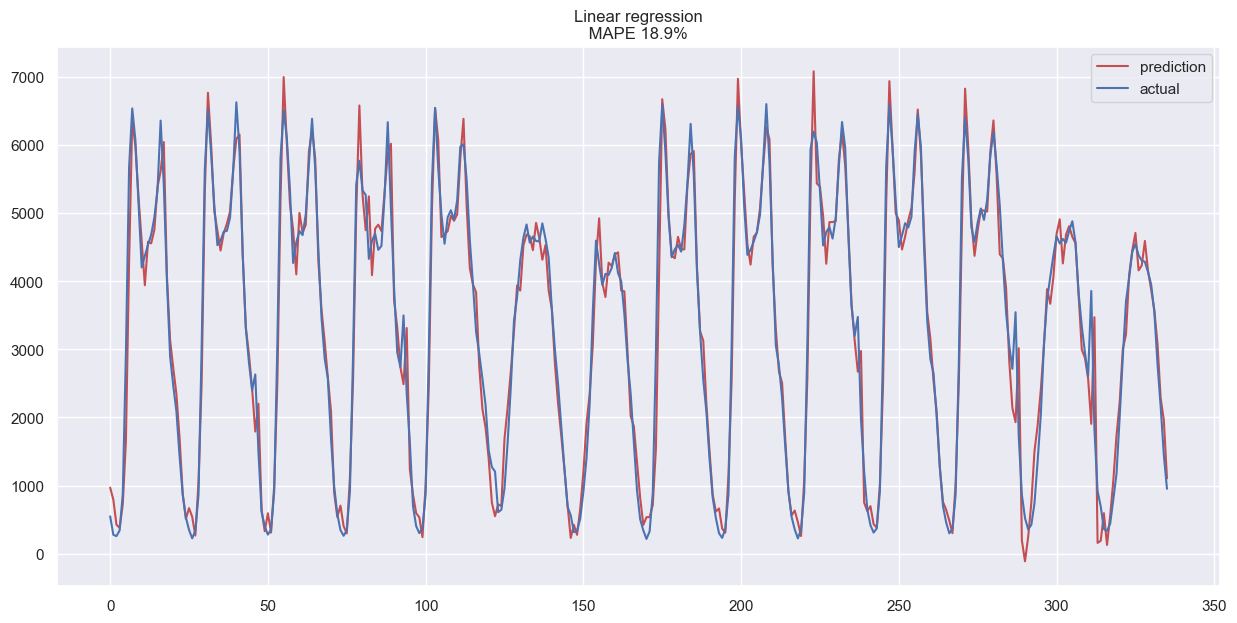

In [41]:
from sklearn.linear_model import LinearRegression

X_train_lr, X_test_lr, y_train_lr, y_test_lr = prepareData(X_lr.traffic_volume, lag_start=1, lag_end=24)
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)
prediction = lr.predict(X_test_lr)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test_lr.values, label="actual")
plt.legend(loc="best")
plt.title(f"Linear regression\n "
          f"MAPE {mean_absolute_percentage_error(prediction, y_test_lr):.1f}% ")
plt.grid(True);

## XGBoost

In [42]:
n_data_points = 24 * 90 # число шагов

X_ = data[-n_data_points:]
X_.temp = X_.temp_interpolated
X_.traffic_volume = X_.traffic_volume_interpolated
X_xgb = X_.loc[:, ['holiday_day', 'temp', 'traffic_volume',]]

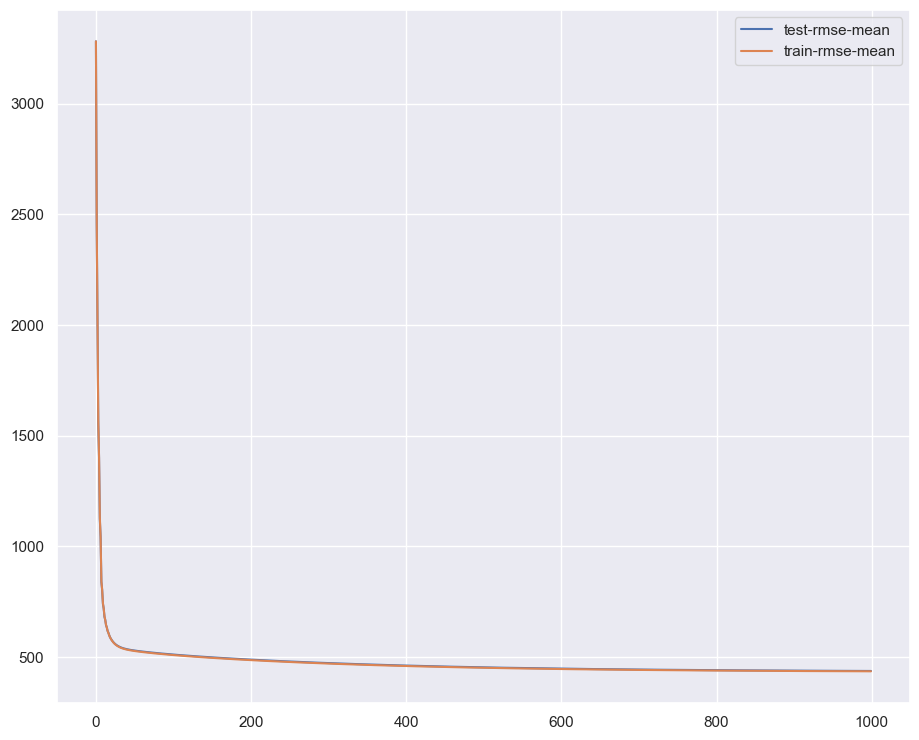

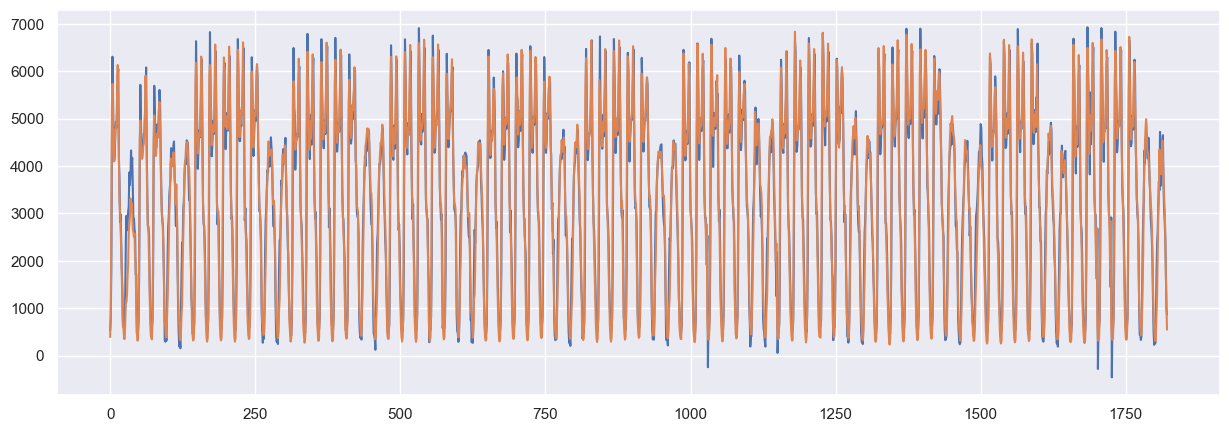

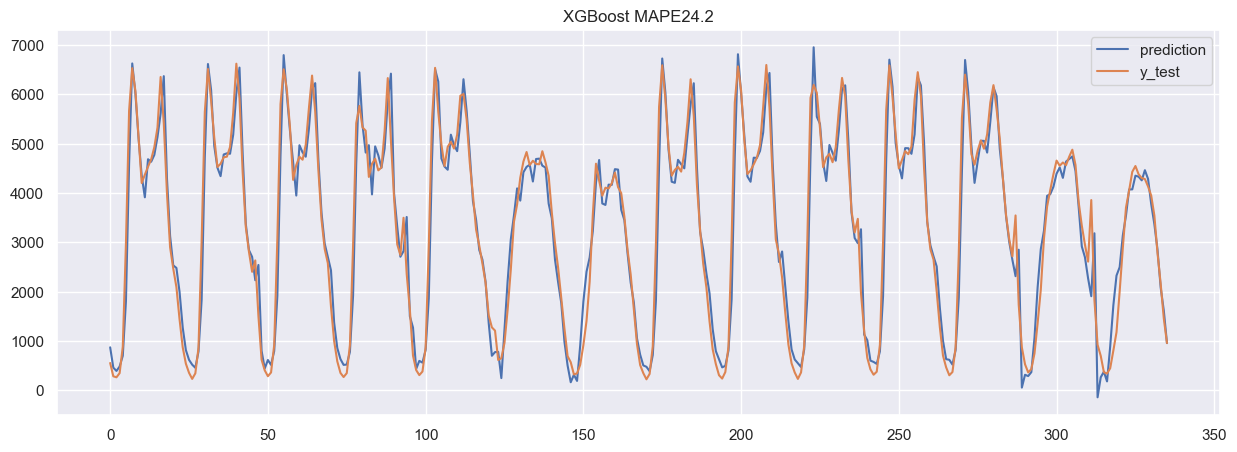

In [48]:
import xgboost as xgb

# исходные данные
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = prepareData(X_xgb.traffic_volume, lag_start=1, lag_end=4)
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb)

# задаём параметры
params = {
    'objective': 'reg:squarederror',
    'booster':'gblinear'
}
trees = 1000

# прогоняем на кросс-валидации с метрикой rmse
cv = xgb.cv(params, dtrain, metrics = 'rmse', verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

# обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

# можно построить кривые валидации
cv.plot(y=['test-rmse-mean', 'train-rmse-mean'])

# запоминаем ошибку на кросс-валидации
deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

# посмотрим, как модель вела себя на тренировочном отрезке ряда
prediction_train = bst.predict(dtrain)
plt.figure(figsize=(15, 5))
plt.plot(prediction_train)
plt.plot(y_train_xgb)
plt.axis('tight')
plt.grid(True)

# и на тестовом
prediction_test = bst.predict(dtest)
lower = prediction_test - 1.96 * deviation
upper = prediction_test + 1.96 * deviation

Anomalies = np.array([np.NaN] * len(y_test_xgb))
Anomalies[y_test_xgb<lower] = y_test_xgb[y_test_xgb<lower]

plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label="prediction")
# plt.plot(lower, "r--", label="upper bond / lower bond")
# plt.plot(upper, "r--")
plt.plot(list(y_test_xgb), label="y_test")
# plt.plot(Anomalies, "ro", markersize=10)
plt.legend(loc="best")
plt.axis('tight')
plt.title(f"XGBoost MAPE{mean_absolute_percentage_error(prediction_test, y_test_xgb):.1f}")
plt.grid(True)
plt.legend()